In [ ]:
import imp
import os
import sys
import math
import re
import numpy as np
from skimage.util import view_as_blocks
import matplotlib.pyplot as plt
import cv2

In [ ]:
gamma = 1.3

In [ ]:
def polar2cart(r, x0, y0, theta):

    x = round(x0 + r * math.cos(theta))
    y = round(y0 + r * math.sin(theta))
    return x, y

In [ ]:
# x,y = polar2cart(13, 0, 0, math.pi/8)

# print(x)
# print(y)

In [ ]:
def gammaCorrection(image):

    lookUpTable = np.empty((1,256), np.uint8)
    for i in range(256):
        lookUpTable[0,i] = np.clip(pow(i / 255.0, 1/gamma) * 255.0, 0, 255)
    res = cv2.LUT(i  mage, lookUpTable)
    return res

In [ ]:
def unravel_iris(img, xp, yp, rp, xi, yi, ri, phase_width=300, iris_width=150):

    if img.ndim > 2:
        img = img[:, :, 0].copy()

    iris = np.zeros((iris_width, phase_width))
    #~create a 150x300 array with null elements
    theta = np.linspace(0, 2 * np.pi, phase_width)
    #?create a vector with phase values

    #^for each phase calculate the cartesian coordinates and the pixel value for these coordinates
    for i in range(phase_width):

        #!calculate the cartesian coordinates for the beginning and the end pixels
        begin = polar2cart(rp, xp, yp, theta[i])
        end = polar2cart(ri, xi, yi, theta[i])

        #&generate the cartesian coordinates of pixels between the beginning and end pixels
        xspace = np.linspace(begin[0], end[0], iris_width)
        yspace = np.linspace(begin[1], end[1], iris_width)

        #*calculate the value for each pixel
        iris[:, i] = [255 - img[int(y), int(x)]
                      if 0 <= int(x) < img.shape[1] and 0 <= int(y) < img.shape[0]
                      else 0
                      for x, y in zip(xspace, yspace)]
                      #*assign the cartesian coordinates
    # print("b", begin, "e", end)



    return iris

In [ ]:
def gabor(rho, phi, w, theta0, r0, alpha, beta):

    return np.exp(-w * 1j * (theta0 - phi)) * np.exp(-(rho - r0) ** 2 / alpha ** 2) *\
           np.exp(-(-phi + theta0) ** 2 / beta ** 2)

In [ ]:
# application of the 2D Gabor wavelets on the image
def gabor_convolve(img, w, alpha, beta):

    # generate the parameters
    theta0 = np.linspace(0, 2 * np.pi, img.shape[1])

    rho = np.array([np.linspace(0, 1, img.shape[0]) for i in range(img.shape[1])]).T
    x = np.linspace(0, 1, img.shape[0])
    y = np.linspace(-np.pi, np.pi, img.shape[1])
    xx, yy = np.meshgrid(x, y)

    return rho * (img * np.real(gabor(xx, yy, w, 0, 0, alpha, beta)).T), \
       rho * (img * np.imag(gabor(xx, yy, w, 0, 0, alpha, beta)).T)


In [ ]:
 def iris_encode(img, dr=15, dtheta=15, alpha=0.4):

    mask = view_as_blocks(np.logical_and(20 < img, img < 255), (dr, dtheta))
    # creating a mask to exclude non-iris pixels

    norm_iris = (img - img.mean()) / img.std()
    # image normalization

    patches = view_as_blocks(norm_iris, (dr, dtheta))
    # split image to blocks


    code = np.zeros((patches.shape[0] * 3, patches.shape[1] * 2))
    # large the size of code to add the information from three frequency and from real and imaginary part

    code_mask = np.zeros((patches.shape[0] * 3, patches.shape[1] * 2))
    for i, row in enumerate(patches):
        for j, p in enumerate(row):
            for k, w in enumerate([8, 16, 32]): #change the frequency of wavelet
                wavelet = gabor_convolve(p, w, alpha, 1 / alpha)
                code[3 * i + k, 2 * j] = np.sum(wavelet[0]) #calculate the real part
                code[3 * i + k, 2 * j + 1] = np.sum(wavelet[1]) #calculate the imaginary part
                code_mask[3 * i + k, 2 * j] = code_mask[3 * i + k, 2 * j + 1] = \
                    1 if mask[i, j].sum() > dr * dtheta * 3 / 4 else 0


    code[code >= 0] = 1
    code[code < 0] = 0
    return code, code_mask

In [ ]:
def preprocess(image):

    img = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    #*convert image to  grayscale

    return cv2.medianBlur(img, 5)
    #!apply the Median Blur filter with a 5X5 kernel


In [ ]:
def find_pupil_hough(img):

    circles = cv2.HoughCircles(img, cv2.HOUGH_GRADIENT, 1, 20,
                               param1=60, param2=30, minRadius=1, maxRadius=40)
    if circles is not None: #^verify if a circle is detected

        circles = np.uint16(np.around(circles))
        return circles[0, 0][0], circles[0, 0][1], circles[0, 0][2]
        #* return x and y coordinates and the radius of the circle
    else:
        return 0,0,0

In [ ]:
def find_iris_hough(img):

    circles = cv2.HoughCircles(img, cv2.HOUGH_GRADIENT, 1, 20,
                               param1=60, param2=30, minRadius=20, maxRadius=100)
    if circles is not None:

        circles = np.uint16(np.around(circles))
        return circles[0, 0][0], circles[0, 0][1], circles[0, 0][2]
    else:
        return 0,0,0

In [ ]:
def compare_codes(a, b, mask_a, mask_b):

    return np.sum(np.remainder(a + b, 2) * mask_a * mask_b) / np.sum(mask_a * mask_b)

In [ ]:
def encode_photo(image):

    src=gammaCorrection(image)
    newImage = src.copy()
    img = preprocess(image)
    img1 = preprocess(newImage)

    x, y, r = find_pupil_hough(img1)
    x_iris, y_iris, r_iris = find_iris_hough(img)

    iris = unravel_iris(image, x, y, r, x_iris, y_iris, r_iris)
    return iris_encode(iris)

In [ ]:
def show_details(image, image2):
    src = gammaCorrection(image)
    newImage = src.copy()
    img = preprocess(image)
    img1 = preprocess(newImage)

    x, y, r = find_pupil_hough(img1)
    x_iris, y_iris, r_iris = find_iris_hough(img)

    iris = unravel_iris(newImage, x, y, r, x_iris, y_iris, r_iris)

    src2 = gammaCorrection(image2)
    newImage2 = src2.copy()
    img2 = preprocess(image2)
    img22 = preprocess(newImage2)

    x2, y2, r2 = find_pupil_hough(img22)
    x2_iris, y2_iris, r2_iris = find_iris_hough(img2)

    iris2 = unravel_iris(newImage2, x2, y2, r2, x2_iris, y2_iris, r2_iris)


0.5104166666666666
Iris match not found


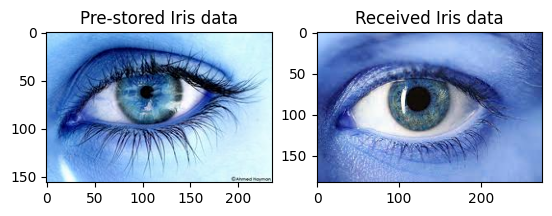

In [ ]:
if __name__ == '__main__':
    # Load images
    image = cv2.imread('pic1.jpg')
    image2 = cv2.imread('pic2.jpg')

    show_details(image, image2)
    code, mask = encode_photo(image)
    code2, mask2 = encode_photo(image2)

    if compare_codes(code, code2, mask, mask2) <= 0.38:
        print(compare_codes(code, code2, mask, mask2))
        print("Iris Match found")

        # Display both images
        plt.figure("Original Image")
        plt.imshow(image)
        plt.figure("Obtained Image")
        plt.imshow(image2)

        # Add title to the figure
        plt.title('Iris Match found')
        plt.show()
    else:
        print(compare_codes(code, code2, mask, mask2))
        print("Iris match not found")

        # Plot difference between the two images
        plt.subplot(121), plt.imshow(image), plt.title('Pre-stored Iris data')
        plt.subplot(122), plt.imshow(image2), plt.title('Received Iris data')
        plt.show()